<a href="https://colab.research.google.com/github/vivek26-1998/Customer-churn-prediction/blob/main/Assignments/Assignment06-Linear%20Classification/Assignment06_2024/linear_Image_classification_MNIST_SVM-HingeLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img align="right" width="400" height="400" src="https://github.com/ML-IGP-TUBS-2024/Keerthiveettil-Vivek/blob/master/Assignments/Assignment06-Linear%20Classification/Assignment06_2024/assets/TUBS_IGP_logo.jpg?raw=1">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) ([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de))

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)  


The general structure of this notebook is a combination of : Jake VanderPlas notebooks,Aurélien Geron notebooks, CS231n notebooks, and Sebastian Raschka's lectures


**Multi-class linear classification exercise**  
Complete and hand in this worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

In this exercise you will:
- get familiar with [**MNIST**](http://yann.lecun.com/exdb/mnist/) dataset
- implement a fully-vectorized loss function for the **Linear SVM**
- implement the fully-vectorized expression for its analytic gradient
- check your implementation using *numerical gradient*
- use a validation set to *tune the learning hyperparameters* (learning rate and regularization strength)
- optimize the loss function with BGD
- visualize the final learned weights
- visualize the misclassifications
- top-k in classification performance
- feature manupulation

# Setup

In [ ]:
# Run some setup code for this notebook.
import numpy as np
import matplotlib.pyplot as plt


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

seed = 57
np.random.seed(seed)

In [ ]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Dataset

Some notes about **[MNIST dataset]((http://yann.lecun.com/exdb/mnist/))**:

- MNIST dataset contains 70,000 handwritten digits.  
- Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms.  
In fact, MNIST is often the first dataset researchers try.  
**"If it doesn't work on MNIST, it won't work at all"** they said.    
Well, if it does work on MNIST, it may still fail on others."

## Loading MNIST dataset

In [ ]:
from os.path  import join
from TUBS_1120019.data_utils import load_MNIST

data_dir = 'TUBS_1120019/datasets/MNIST_784'

X_train, X_test, y_train, y_test = load_MNIST(data_dir)


loading MNISt data from: TUBS_1120019/datasets/MNIST_784   finished.


In [ ]:
# As a sanity check of loading the dataset, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape,X_train.dtype)
print('Training labels shape: ', y_train.shape,y_train.dtype)
print('Test data shape: ', X_test.shape,X_test.dtype)
print('Test labels shape: ', y_test.shape,y_test.dtype)

Training data shape:  (60000, 28, 28) float64
Training labels shape:  (60000,) uint8
Test data shape:  (10000, 28, 28) float64
Test labels shape:  (10000,) uint8


In [ ]:
K = np.max(y_train)+1 # Number of classes
print(f"Number of classes = {K}")

Number of classes = 10


## Visualize the dataset

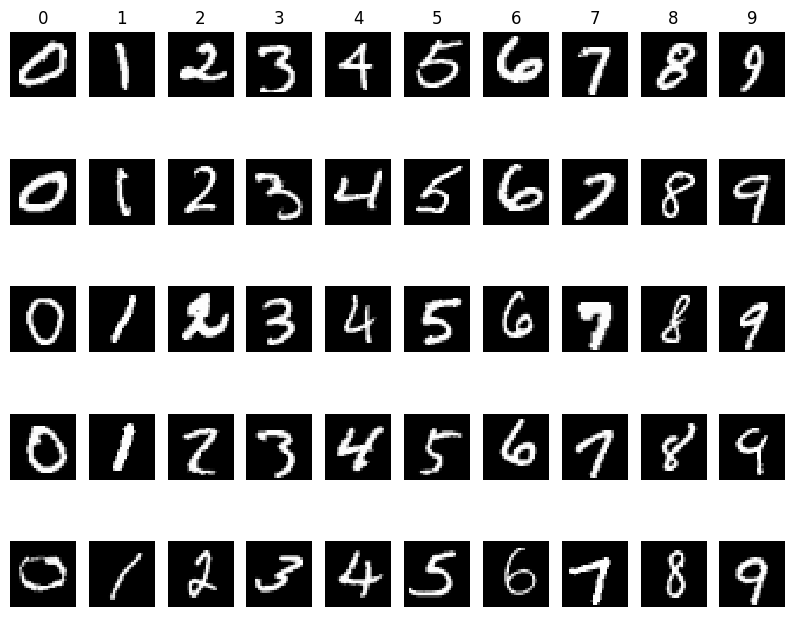

In [ ]:
# Visualize some samples from the dataset.
# We show a few random samples of training images from each class.
num_classes = K
samples_per_class = 5
for y in range(K):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(y)
plt.show()

## Data preparation and preprocessing

We will use trainSet(X_train,y_train) for our implementation.  
<font color='black'>The testSet(X_test,y_test) should be held out for final evaluation</font>

But for hyperparameter tuning we need another set.  
So, after splitting our dataset into trainSet and testSet,  
we will further split the trainSet to two sets for training and validation

Scikitlearn has a function for this:
[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)  
But, in this assignment you should use your own function using numpy and plain python


**Note: Use a small subset of data for development**   
   
You can use small subset(e.g. 10%) of data for development to do and check your implementation faster.  
When everything works, you can use the full dataset.  

### Split the training data into train, and validation set

Open `TUBS_1120019/data_utils.py` and implement the function `split_into_2_sets`  

In [ ]:
from TUBS_1120019.data_utils import split_into_2_sets
X_train, X_val, y_train, y_val   = split_into_2_sets(X_train, y_train, first_set_size=0.8,shuffle=True, random_state=seed)

In [ ]:
# As a sanity check, we print out the size of the training, validation and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (48000, 28, 28)
Training labels shape:  (48000,)
Validation data shape:  (12000, 28, 28)
Validation labels shape:  (12000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape  : ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape      : ', X_test.shape)

Training data shape  :  (48000, 784)
Validation data shape:  (12000, 784)
Test data shape      :  (10000, 784)


Before training our classifier(just doing a random guess for the labels of the sample)
and if we have K classes, the accuracy of the results should be aruond 1/K which is 1/10 for our dataset

In [ ]:
y_train_predicted_random = np.random.randint(10,size=X_train.shape[0],dtype=int)
print("Accuracy of random classification: ",np.mean(y_train_predicted_random==y_train))

Accuracy of random classification:  0.1008125


In [ ]:
D = X_train.shape[-1]  # Number of features
N_train = X_train.shape[0] # Number of training samples
N_valid = X_val.shape[0] # Number of validation samples
N_test  = X_test.shape[0] # Number of test samples


# generate a random weight matrix of small numbers
W=np.random.randn(D,K)*0.0001
bias=np.ones((1,K))

# bias trick
# append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W
W_with_biasTerm=np.vstack((bias, W)) # add bias as a column to W

bias_coef = np.ones((N_train,1))
X_train_with_biasTerm=np.hstack((bias_coef,X_train))# add a column containing ones as bias feature

bias_coef = np.ones((N_valid,1))
X_val_with_biasTerm=np.hstack((bias_coef,X_val))# add a column containing ones as bias feature

bias_coef = np.ones((N_test,1))
X_test_with_biasTerm=np.hstack((bias_coef,X_test))# add a column containing ones as bias feature

In [ ]:
# As a sanity check, print out the shapes of the data
print('Training data shape  : ', X_train_with_biasTerm.shape)
print('Validation data shape: ', X_val_with_biasTerm.shape)
print('Test data shape      : ', X_test_with_biasTerm.shape)

Training data shape  :  (48000, 785)
Validation data shape:  (12000, 785)
Test data shape      :  (10000, 785)


# Classifier: Linear SVM

Your code for this section will all be written inside `TUBS1120019/classifiers/`

As you can see, we have prefilled the function svm_loss_naive which uses _for_ loops to evaluate the multiclass SVM loss function.

## Naive implementation of the loss

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from TUBS_1120019.classifiers.linear_svm import svm_loss_naive

loss, grad = svm_loss_naive(W_with_biasTerm, X_train_with_biasTerm, y_train,reg=0.000005)
print('loss: %f' % (loss, ))

loss: 9.163203


## Naive implementation of the gradient (2pnts)

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.


## Numerical gradient check

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from TUBS_1120019.numerical_gradient_check import gradient_check_sparse

f = lambda w: svm_loss_naive(w,X_train_with_biasTerm,y_train,reg = 0.0)
grad_numerical = gradient_check_sparse(f,W_with_biasTerm)

numerical:  33.25562500 ,analytic:  33.25562500, relative error: 1.245109e-12
numerical:   1.76256250 ,analytic:   1.76256250, relative error: 3.887759e-11
numerical:  12.91439972 ,analytic:  12.91300000, relative error: 5.419501e-05
numerical:   0.16877083 ,analytic:   0.16877083, relative error: 3.361558e-10
numerical:   7.86306250 ,analytic:   7.86306250, relative error: 8.343536e-12
numerical:   0.47025000 ,analytic:   0.47025000, relative error: 2.901628e-10
numerical: -83.20728218 ,analytic: -83.20737500, relative error: 5.577478e-07
numerical:   0.16510417 ,analytic:   0.16510417, relative error: 8.249721e-11
numerical:  -3.77342632 ,analytic:  -3.77281250, relative error: 8.134105e-05
numerical:  11.40389583 ,analytic:  11.40389583, relative error: 8.061360e-12


In [ ]:
# do the gradient check once again with regularization turned on
f = lambda w: svm_loss_naive(w,X_train_with_biasTerm,y_train,reg = 5e-6)
grad_numerical = gradient_check_sparse(f,W_with_biasTerm)

numerical: -48.64776490 ,analytic: -48.65089584, relative error: 3.217864e-05
numerical: -11.64816538 ,analytic: -11.65052083, relative error: 1.010979e-04
numerical:   0.00066667 ,analytic:   0.00066667, relative error: 4.809940e-09
numerical:   0.05491667 ,analytic:   0.05491667, relative error: 2.826354e-10
numerical:   0.25683333 ,analytic:   0.25683333, relative error: 3.117065e-10
numerical:   0.85881250 ,analytic:   0.85881250, relative error: 3.730285e-11
numerical:   0.00000000 ,analytic:   0.00000000, relative error: 8.470820e-03
numerical:   0.00000000 ,analytic:   0.00000000, relative error: 1.253714e-01
numerical:  -3.83740172 ,analytic:  -3.83962500, relative error: 2.896021e-04
numerical:  -0.00000000 ,analytic:  -0.00000000, relative error: 5.751808e-03


## Vectorized implementation of the loss (5pnts)

In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
import time
tic = time.time()
loss_naive, _ = svm_loss_naive(W, X_train, y_train, reg=5e-6)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from TUBS_1120019.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, reg=5e-6)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.163153e+00 computed in 10.449603s
Vectorized loss: 9.163153e+00 computed in 0.236311s
difference: 0.000000


## Vectorized implementation of the gradient (5pnts)

In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
import time
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 6.018371s
Vectorized loss and gradient: computed in 0.192275s
difference: 2226.669142


## Mini-Batch Gradient Descent

We now have the loss and its gradient. We are therefore ready to do BGD (some people consider BGD as SGD) to minimize the loss.
Your code for this part will be written inside `.../classifiers/linear_classifier.py`.

### train (3pnts)
Derive and implement the training part of the linear classifer inside the function "Linear_classifier.train".

In [ ]:
from TUBS_1120019.classifiers import LinearSVM
classifier = LinearSVM()
loss_history =classifier.train(X_train_with_biasTerm, y_train,
                               learning_rate=1e-7, reg=2.5e4,
                               batch_size=100,num_iters=200, verbose=True)

iteration     0/  200: loss 9.020054
iteration   100/  200: loss 1.977345


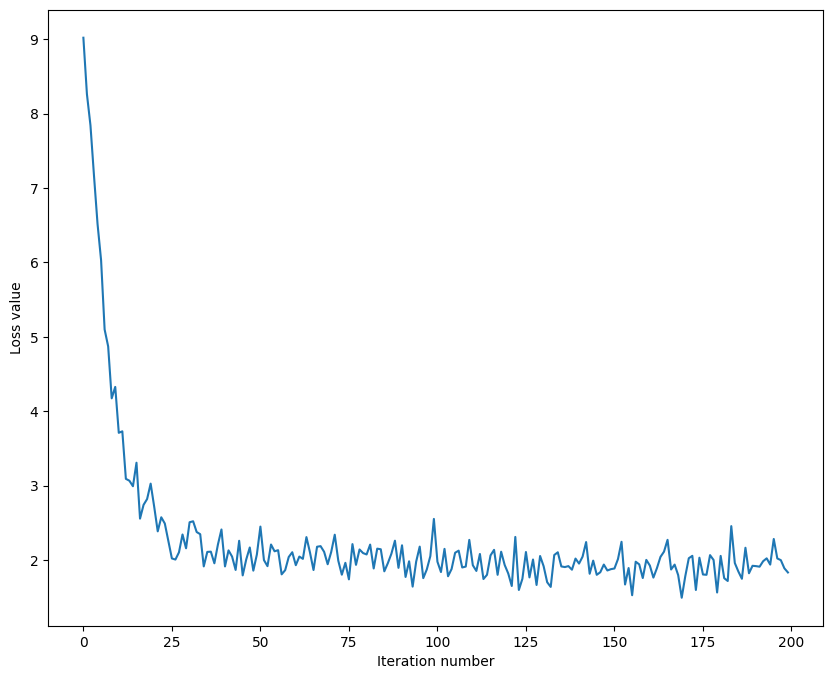

In [ ]:
# A useful debugging strategy is to plot the loss as a function of iteration number:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

## predict (2pnts)

In [ ]:
# Write the Linear_classifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train_with_biasTerm)
print('training accuracy: ',np.mean(y_train == y_train_pred))

(48000, 785) (785, 10)
training accuracy:  0.8599375


In [ ]:
y_val_pred = classifier.predict(X_val_with_biasTerm)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))


(12000, 785) (785, 10)
validation accuracy: 0.863583


In [ ]:
y_test_pred = classifier.predict(X_test_with_biasTerm)
print('test accuracy: %f' % (np.mean(y_test == y_test_pred), ))


(10000, 785) (785, 10)
test accuracy: 0.869600


## Tuning the hyperparameters (10pnts)

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of more than 90% on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm. Also store best parameters in a list called best_setting#
# best_setting = [best_learning_rate, best_regularization_strength]            #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train;once you are  #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-6,1e-1,9e-1]
regularization_strengths = [1e-5,1e-1,0,5e1]
num_iters = 200

for lr in learning_rates:
    for reg in regularization_strengths:
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        svm = LinearSVM()
        loss_history = svm.train(
            X_train_with_biasTerm, y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=num_iters,
            verbose=False
        )

        # Compute training and validation accuracies
        y_train_pred = svm.predict(X_train_with_biasTerm)
        y_val_pred = svm.predict(X_val_with_biasTerm)
        training_accuracy = np.mean(y_train_pred == y_train)
        validation_accuracy = np.mean(y_val_pred == y_val)

        # Store results in the dictionary
        results[(lr, reg)] = (training_accuracy, validation_accuracy)

        # Update the best parameters if validation accuracy improves
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
            best_setting = [lr, reg]

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        print("learning rate =%2.2e, regularization_strengths=%2.0e ==>  train accuracy=%3.3f, val accuracy=%3.3f"%(lr,reg,training_accuracy,validation_accuracy))

print('\nBest validation accuracy: %f' % best_val)
print(f"learning_rate = {best_setting[0]},\
      regularization_strengths={best_setting[1]:.0e}")

(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-06, regularization_strengths=1e-05 ==>  train accuracy=0.903, val accuracy=0.898
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-06, regularization_strengths=1e-01 ==>  train accuracy=0.899, val accuracy=0.898
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-06, regularization_strengths=0e+00 ==>  train accuracy=0.900, val accuracy=0.897
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-06, regularization_strengths=5e+01 ==>  train accuracy=0.892, val accuracy=0.889
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-01, regularization_strengths=1e-05 ==>  train accuracy=0.881, val accuracy=0.878
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-01, regularization_strengths=1e-01 ==>  train accuracy=0.488, val accuracy=0.478
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-01, regularization_strengths=0e+00 ==>  train

C:\Users\K VIVEK\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\K VIVEK\Desktop\TUB notes and assignments\ML\Keerthiveettil-Vivek\Assignments\Assignment06-Linear Classification\Assignment06_2024\TUBS_1120019\classifiers\linear_svm.py:110: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)  # Add regularization


(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =1.00e-01, regularization_strengths=5e+01 ==>  train accuracy=0.004, val accuracy=0.004
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =9.00e-01, regularization_strengths=1e-05 ==>  train accuracy=0.877, val accuracy=0.875
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =9.00e-01, regularization_strengths=1e-01 ==>  train accuracy=0.348, val accuracy=0.350
(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =9.00e-01, regularization_strengths=0e+00 ==>  train accuracy=0.884, val accuracy=0.883


C:\Users\K VIVEK\Desktop\TUB notes and assignments\ML\Keerthiveettil-Vivek\Assignments\Assignment06-Linear Classification\Assignment06_2024\TUBS_1120019\classifiers\linear_svm.py:110: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)  # Add regularization
C:\Users\K VIVEK\Desktop\TUB notes and assignments\ML\Keerthiveettil-Vivek\Assignments\Assignment06-Linear Classification\Assignment06_2024\TUBS_1120019\classifiers\linear_svm.py:101: RuntimeWarning: overflow encountered in matmul
  scores = X @ W  # Shape (N, K)
C:\Users\K VIVEK\Desktop\TUB notes and assignments\ML\Keerthiveettil-Vivek\Assignments\Assignment06-Linear Classification\Assignment06_2024\TUBS_1120019\classifiers\linear_svm.py:105: RuntimeWarning: overflow encountered in subtract
  margins = np.maximum(0, scores - correct_class_scores + delta)  # Shape (N, K)
C:\Users\K VIVEK\Desktop\TUB notes and assignments\ML\Keerthiveettil-Vivek\Assignments\Assignment06-Linear Classification\Assignme

(48000, 785) (785, 10)
(12000, 785) (785, 10)
learning rate =9.00e-01, regularization_strengths=5e+01 ==>  train accuracy=0.098, val accuracy=0.100

Best validation accuracy: 0.898333
learning_rate = 1e-06,      regularization_strengths=1e-01


## Report the results on test set

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test_with_biasTerm)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

(10000, 785) (785, 10)
linear SVM on raw pixels final test set accuracy: 0.904700


without any preprocessing and with  200 iterations, we achieved more than 90%  test set accuracy  
without any preprocessing and with 5000 iterations, we can achieve more than 92%  test set accuracy   


this is close to the [highest reported test set accuracy using __linear classifier with deskewing__](http://yann.lecun.com/exdb/mnist/)

**However:**
SOTA is more than 99.5%
We will learn about those approaches later.

## Visualizing and interpreting the outputs

### Visualizing the weights

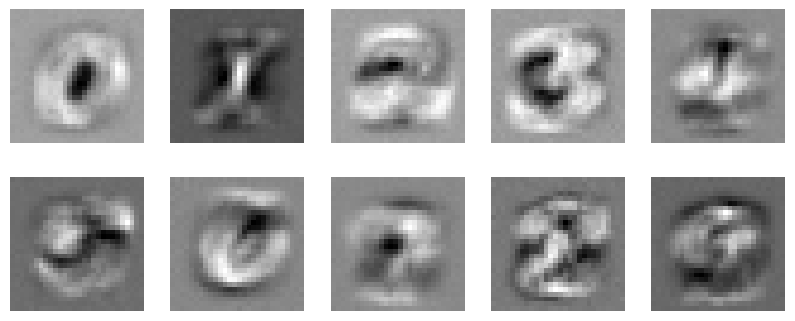

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
plt.rcParams['figure.figsize'] = (10.0, 4.0) # set default size of plots

w = best_svm.W[1:,:] # strip out the bias
w = w.T.reshape(10,28, 28)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    w_min, w_max = np.min(w[ i, :, :]), np.max(w[ i, :, :])

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[ i, :, :].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')

**Inline Question** (2pnts)
- How do you we interpret this figure? (What do you understand from subfigures? Maybe nothing!!)  
$\color{blue}{\textit{Your Answer: The figure shows learned weights of the softmax classifier for each digit class, they are essentially the features the mode has learned during training}}$
<font color='blue'>*Your Explanation*:we can observe that the subfigures corresponding to each digit appear to show distinct and recognizable patterns. For example, the subfigure for class "1" might look like a vertical line, while the subfigure for "2" may appear as a curved pattern, which matches the typical shape of the digit. The clarity and distinctness of these weight images suggest that the model has learned meaningful features that correspond to the characteristics of each digit,blurriness or similarity in images may indicate model has effectively not learned to distingish between classes</font>

### Visualizing wrong predictions
Finally, let's have a look on some wrong predictions in test dataset

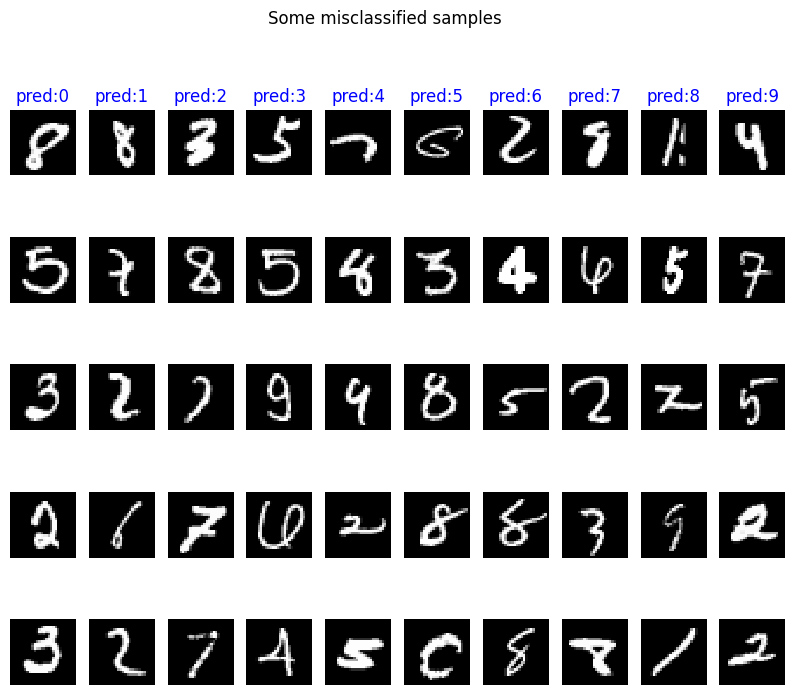

In [ ]:
fig = plt.figure(figsize=(10.0, 8.0))
fig.suptitle('Some misclassified samples', fontsize=12)

# Visualize some samples from the dataset.
# We show a few random samples of test images from each class.
X_test_28x28 = X_test.reshape(X_test.shape[0],28,28)
samples_per_class = 5
for k in range(K):
    idxs_pred_k=np.flatnonzero(y_test_pred==k)
    idxs_pred_k_wrong  = np.flatnonzero(y_test[idxs_pred_k]!=y_test_pred[idxs_pred_k])
    idxs = np.random.choice(idxs_pred_k_wrong, samples_per_class, replace=False)
    X_test_misclassified_k = X_test_28x28[idxs_pred_k[idxs]]
    y_test_misclassified_k = y_test[idxs_pred_k[idxs]]
    y_test_pred_misclassified_k = y_test_pred[idxs_pred_k[idxs]]
    for i, idx in enumerate(idxs):
        plt_idx = (i * K)+k+1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test_misclassified_k[i].astype('uint8'))
        plt.axis('off')
        if i == 0:
            string_pred='pred:'+str(k)
            plt.title(string_pred,color='blue')

plt.show()

# Error Analysis

## Confusion Matrix

Analyzing the confusion matrix often gives you insights into ways to improve your classifier.

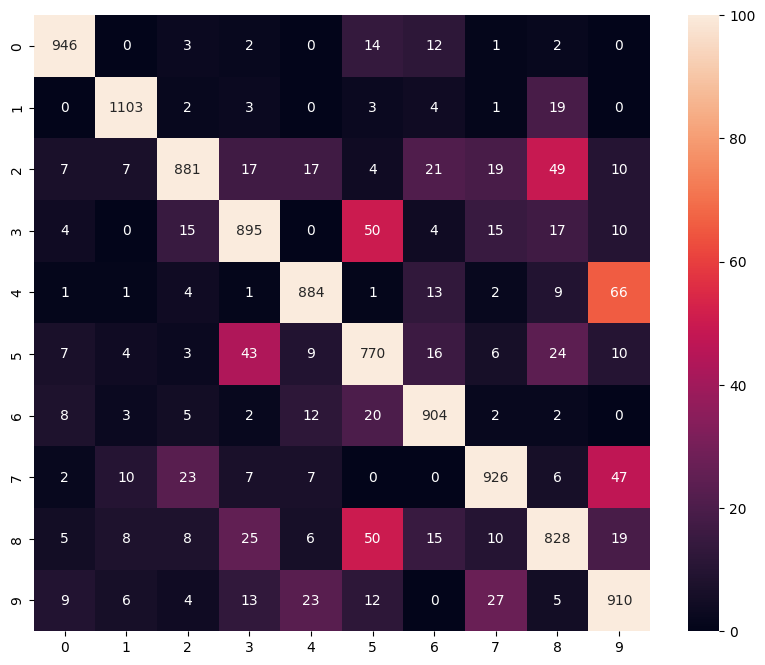

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix(y_test,y_test_pred)

fig = plt.figure(figsize=(10.0, 8.0))
ax = sns.heatmap(confusion_matrix(y_test,y_test_pred), annot=True, fmt="d", vmax=100, square=True)

**Inline Question** (3pnts)
  
- Which number is the best separated class?  
$\color{blue}{\textit{Your Answer: Class 1 is the best-separated class.}}$
<font color='blue'>*Your Explanation (Discussion and computation)*: The diagonal value for class 1 is 1103, and there are very few off-diagonal values (indicating misclassifications). This shows that class 1 is accurately classified in most cases, with minimal confusion with other classes.</font>

- Which number is the worst separated class?  
$\color{blue}{\textit{Your Answer: Class 8 is the worst-separated class.}}$  
<font color='blue'>*Your Explanation (Discussion and computation)*: Class 8 has the lowest diagonal value (828) relative to the other classes, and it shows significant confusion with classes 5 and 6, as seen from higher off-diagonal values (e.g., 50 misclassified as class 5 and 50 misclassified as class 6).</font>

- Which pairs pf classes are harder to be separated? write 2 of the pairs  
$\color{blue}{\textit{Your Answer: Two pairs of classes that are harder to separate are:
Classes 4 and 9
Classes 8 and 5}}$  
<font color='blue'>*Your Explanation (Discussion and computation)*:Between classes 4 and 9: There are 66 misclassifications where class 4 is classified as class 9, and 47 misclassifications where class 9 is classified as class 4. This indicates significant confusion between these two classes.
Between classes 8 and 5: There are 50 misclassifications where class 8 is classified as class 5. This shows difficulty in distinguishing between these two classes as well.</font>

## best_k (10pnts)

For some applications like search engines and recommender systems, we are interested not only in the best element, but also in the  first k items. So, the first elements of the search result are most relevant for the user. Here, evaluating just how relevant/accurate the top element is, could not be a good metric for the problem.

In some applications top_k is not a good solution, but we will implement it to better understand the idea behind top_k.


In [ ]:
# Write the LinearSVM.predict_top_k function and
# evaluate the performance of the best classifier on test set using top_k
# assign the outputs to 2 variables 'test_scores_top_k', and 'test_top_k'
classifier = best_svm
test_scores_top_k, test_top_k = classifier.predict_top_k(X_test_with_biasTerm,k=3)
print('test accuracy: ',np.mean([(y_test[i] in test_top_k[i]) for i in range(len(y_test))]))

test accuracy:  0.9814


# Feature manupulation (40pnts)

Select and solve one of the following problems:
- Shuffling the features
- Feature selection
- Normalizing the features

## Shuffling the features

What happens if we change the order of the features (columns of X before adding bias_term), randomly.  
Unless we keep the shuffling indices and use them for rearranging the pixels, we will have problem in visualization of the samples  
But, what about classification? Does shuffling the features affect the results or not?  
Feel free to add some cells here to ivestigate this effect.  
You can also copy this notebook, and ivestigate shuffling the features, in a separate notebook.  

## Feature selection

As a very simple feature selection strategy, one idea could be to ignore some first/last rows and column of the all samples and analyze the results.  
So, your task is to remove `n_ignores_rows` and `n_ignored_cols` from all samples and compute the classiication accuracy.  
`n_rows=1` means that you ignore first and last rows of the samples

for examples you may report the decrease of the accuracy as:  

n_ignored_rows =0, n_ignored_cols=0 ==> test accuracy = 0.90 <-- Baseline  
n_ignored_rows =0, n_ignored_cols=1 ==> test accuracy = 0.89  
n_ignored_rows =1, n_ignored_cols=0 ==> test accuracy = 0.90  
n_ignored_rows =1, n_ignored_cols=1 ==> test accuracy = 0.88  
...  


## Normalizing the features
What happens if we normalize the inputs?

what about: (zero-centering)?
- subtract the mean image
    - first: compute the mean image based on the training data
    - second: subtract the mean image from train and test data
    
what if we also do scaling?    
- divide by standard deviation image
    - first: compute the std image based on the training data
    - second: divide the zero-centered train and zero-centered test data by std image

By combining zero-centering and scaling, the data becomes standardized, which:
Ensures each feature (pixel) has mean 0 and variance 1.
Improves the numerical stability of optimization, especially for neural networks or linear classifiers.
Effect on accuracy:
Training Efficiency: Normalization accelerates convergence during training by eliminating bias introduced by feature scales.
Improved Generalization: Models trained on normalized inputs often perform better on unseen data.
Better Stability: Prevents exploding/vanishing gradients in neural networks.
While normalization usually improves accuracy, the extent of the improvement depends on the model and dataset

In [ ]:
epsilon = 1e-8  # Small value to prevent division by zero

# Step 1: Zero-center the data
mean_image = np.mean(X_train, axis=0)
X_train_zero_centered = X_train - mean_image
X_val_zero_centered = X_val - mean_image
X_test_zero_centered = X_test - mean_image

# Step 2: Scale the data
std_image = np.std(X_train, axis=0)
std_image = np.where(std_image == 0, epsilon, std_image)  # Replace zeros with epsilon
X_train_normalized = X_train_zero_centered / std_image
X_val_normalized = X_val_zero_centered / std_image
X_test_normalized = X_test_zero_centered / std_image

# Step 3: Add bias term
X_train_normalized_with_biasTerm = np.hstack((np.ones((N_train, 1)), X_train_normalized))
X_val_normalized_with_biasTerm = np.hstack((np.ones((N_valid, 1)), X_val_normalized))
X_test_normalized_with_biasTerm = np.hstack((np.ones((N_test, 1)), X_test_normalized))

# Step 4: Train the classifier and evaluate
classifier = LinearSVM()  # Ensure you have a defined LinearClassifier class with train and predict methods

# Train the classifier on the training data
classifier.train(X_train_normalized_with_biasTerm, y_train, learning_rate=0.1, reg=1e-05, num_iters=200)

# Step 5: Evaluate accuracy
y_train_pred = classifier.predict(X_train_normalized_with_biasTerm)
print('Training accuracy:', np.mean(y_train == y_train_pred))

y_val_pred = classifier.predict(X_val_normalized_with_biasTerm)
print('Validation accuracy: %f' % np.mean(y_val == y_val_pred))

y_test_pred = classifier.predict(X_test_normalized_with_biasTerm)
print('Test accuracy: %f' % np.mean(y_test == y_test_pred))


iteration     0/  200: loss 9.000207
iteration   100/  200: loss 0.270913
(48000, 785) (785, 10)
Training accuracy: 0.9111875
(12000, 785) (785, 10)
Validation accuracy: 0.899583
(10000, 785) (785, 10)
Test accuracy: 0.905800


In [ ]:
##Normalising

# Bonus

##  Visualizing W of all classes during training (20 pnts)
writing the code to generate a video (like a timelapse) to visualize W of all classes during training